In [2]:
import copy
import os
import random
import uuid
from dataclasses import asdict, dataclass
from pathlib import Path

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt

import yaml
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

import sys
sys.path.append('../scripts')
import pickle
from tensordict import MemoryMappedTensor, TensorDict

from actor_utils import *
from utils import *

In [3]:
checkpoints_path = "/home/lucas/Workspace/CORL/out"
run_name = "BC-evasion-v2-72984cb0"
model_dict = torch.load(os.path.join(checkpoints_path, run_name, "checkpoint_3M.pt"))

In [5]:
with open(os.path.join(checkpoints_path, run_name, "config.yaml"),"r") as file_object:
    config = yaml.load(file_object,Loader=yaml.SafeLoader)

In [7]:
# Set environment parameters.
img_size = config['env']['img_size']
time_max = config['env']['max_time_step']
observation_img_size = [1, img_size, img_size]
action_dim = config['env']['action_dim']
action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(action_dim,))
map_size = config['env']['map_size']
if config['env']['observation']['goal_direction_normalized']:
    observation_space= gym.spaces.Dict({"heat_map": gym.spaces.Box(0, 255, observation_img_size), 
                            "goal_direction": gym.spaces.Box(-1, 1, shape=(2,)),
                            'time_spent': gym.spaces.Box(low=1.0, high=np.inf, shape=(1,))})
else:
    observation_space= gym.spaces.Dict({"heat_map": gym.spaces.Box(0, 255, observation_img_size), 
                            "goal_direction": gym.spaces.Box(-map_size / 2.0, map_size / 2.0, shape=(2,)),
                            'time_spent': gym.spaces.Box(low=1.0, high=np.inf, shape=(1,))})

In [8]:
model_dict

{'actor': OrderedDict([('log_std',
               tensor([-12.1392, -12.4177], device='cuda:0')),
              ('feature_extractor.extractors.heat_map.cnn.0.weight',
               tensor([[[[ 3.8967e-02,  1.0557e-01,  6.8296e-02,  ...,  1.1519e-01,
                           3.9247e-02, -8.3594e-03],
                         [ 1.1790e-01, -3.1566e-02,  4.1040e-02,  ...,  7.5315e-02,
                           3.3561e-02,  7.9288e-02],
                         [ 1.0660e-01, -8.3664e-02,  8.3750e-02,  ..., -1.6042e-02,
                          -9.2188e-02, -1.0766e-01],
                         ...,
                         [-1.1084e-01,  6.2671e-02,  9.5952e-02,  ..., -1.4414e-02,
                          -4.7987e-02, -1.4986e-02],
                         [-6.6503e-03,  1.1492e-02, -6.6748e-02,  ...,  6.9497e-02,
                          -1.1348e-01,  2.2203e-02],
                         [ 1.7264e-02,  2.0383e-02, -6.2894e-02,  ...,  8.7287e-02,
                           9.0378e

### Load Actor ###

In [9]:
assert config['policy']['hidden_act'] == 'Tanh' or config['policy']['hidden_act'] == 'ReLU', "Currently only support ReLU or Tanh."
if config['policy']['hidden_act'] == 'Tanh':
    actor = ActorNet(observation_space, action_space, config['policy']['actor_net_hidden'], hidden_act=nn.Tanh)
if config['policy']['hidden_act'] == 'ReLU':
    actor = ActorNet(observation_space, action_space, config['policy']['actor_net_hidden'], hidden_act=nn.ReLU)
actor.load_state_dict(model_dict['actor'])
actor.eval()

ActorNet(
  (feature_extractor): FeatureExtractor(
    (extractors): ModuleDict(
      (goal_direction): Flatten(start_dim=1, end_dim=-1)
      (heat_map): NatureCNN(
        (cnn): Sequential(
          (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
          (1): ReLU()
          (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
          (3): ReLU()
          (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          (5): ReLU()
          (6): Flatten(start_dim=1, end_dim=-1)
        )
        (linear): Sequential(
          (0): Linear(in_features=5184, out_features=256, bias=True)
          (1): ReLU()
        )
      )
      (time_spent): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (policy_net): Sequential(
    (0): Linear(in_features=259, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
  )
  (action_net): Linear(in_features=64, out_features=2, bias=True)
)

### Load one of the training data ###

In [12]:
delta_t = config['env']['delta_t']
V = config['env']['V']
radar_radius = config['env']['radar_radius']
aircraft_detection_range = config['env']['aircraft_detection_range']
grid_size=2*aircraft_detection_range/img_size
time_scaling = config['env']['observation']['time_scaling']
action_rescaling = map_size / 2.0

In [30]:
episode_idx = 0
data_path = "/home/lucas/Workspace/evasion_guidance/evasion_guidance/data/"
episode_dict = np.load(data_path + f'episode_{episode_idx}.npy',allow_pickle='TRUE').item()

state_cur = episode_dict['start_state']
radar_locs = episode_dict['radar_locations']
radar_orientations = episode_dict['radar_orientations']
goal_location = episode_dict['goal_location']


time_spent = 0

trajectory = [state_cur]
q_values = []
with torch.no_grad():
    # while np.linalg.norm(state_cur[:2] - goal_location) > config['env']['goal_tolerance']:
    for i in range(len(episode_dict['state_history'])):
        # print("Time spent: ", time_spent)
        if time_spent % 10 == 0:
            print("Time spent: ", time_spent)
        if time_spent > config['env']['max_time_step']:
            print("Reached time limit.")
            break
        obs = TensorDict({
            'heat_map': torch.from_numpy(get_radar_heat_map(state_cur, radar_locs, img_size,
                                           aircraft_detection_range,
                                           grid_size, 
                                           radar_radius)).unsqueeze(dim=0).float(),
            'goal_direction': torch.from_numpy((goal_location - state_cur[:2]) / (map_size / 2.0)).unsqueeze(dim=0).float(),
            'time_spent': torch.from_numpy(np.asarray([np.exp(time_spent/time_scaling)])).unsqueeze(dim=0).float()
        })
        # print(obs)
        # print("State: ", state_cur)
        u, _ = actor(obs)
        # print(u)
        u = action_rescaling*u
        # print(u.numpy()[0])
        # state_cur = state_cur + delta_t*np.array([V*np.cos(state_cur[2]), V*np.sin(state_cur[2]), u.flatten().numpy()[0]/V])
        u = u.numpy()[0]
        state_cur = np.asarray([state_cur[0] + u[0], state_cur[1] + u[1], episode_dict['state_history'][time_spent, 2]])
        # print(state_cur)
        # print(state_cur)
        time_spent += 1
        # print(state_cur)
        trajectory.append(state_cur)
trajectory = np.asarray(trajectory)

Time spent:  0
Time spent:  10
Time spent:  20
Time spent:  30


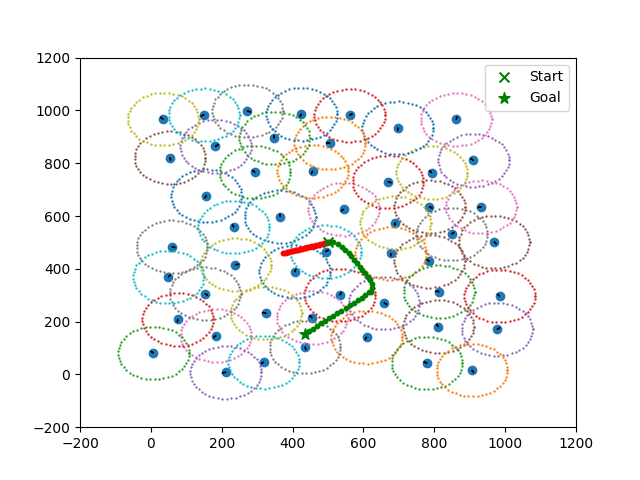

In [31]:
plt.close()
fig, ax = plt.subplots()
visualiza_radar_config(radar_locs, radar_orientations, radius=radar_radius, xlim=[0, map_size], ylim=[0, map_size])


ax.scatter(trajectory[:, 0], trajectory[:, 1], s=10, c='r')
ax.scatter(episode_dict['state_history'][:, 0], episode_dict['state_history'][:, 1], s=10, c='g')
ax.scatter(episode_dict['start_state'][0], episode_dict['start_state'][1], s=50, c='g', marker='x', label="Start")
ax.scatter(goal_location[0], goal_location[1], s=70, c='g', marker='*', label='Goal')

ax.set_xlim(-200, 1.2*map_size)
ax.set_ylim(-200, 1.2*map_size)
ax.legend()
plt.show()